# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Constants

In [2]:
# Panama
PA_FIRST_LOCATION_RUN = False

pa_shape_path = "data/Panama/panama_rect.shx"

pa_s2_rasters = ["data/Panama/S2_panama_T17PPK_20211210.tif", "data/Panama/S2_panama_T17PPL_20221210.tif"]
pa_s2_merged_path = "data/Panama/S2_merged_20211210.tif"
pa_s2_path = 'data/Panama/S2_merged_20211210_reproj.tif'

pa_s1_no_process_path = "data/Panama/S1_inter_20220128_20220209.geo.unw.tif"
pa_s1_path = 'data/Panama/S1_inter_20220128_20220209_reproj.geo.unw.tif'

pa_capella_path = "data/Panama/CAPELLA_C09_SM_GEO_HH_20240806035526_20240806035544.tif"

pa_iceye_no_process_path = "data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC.tif"
pa_iceye_path = 'data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC_reproj.tif'

EXPERIMENT_RUN = 'all' # 'optical', 'interferogram', 'all', 'iceye'
NUM_SIMULATIONS = 1

# Data preprocessing

#### Set up

In [3]:
pa_aoi = dp.get_aoi_geometry(pa_shape_path, PA_FIRST_LOCATION_RUN)
pa_aoi = pa_aoi.set_crs("EPSG:4326", allow_override=True)

if PA_FIRST_LOCATION_RUN:
    dp.get_sentinel2(pa_aoi, pa_s2_path, pa_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=pa_s2_merged_path, list_files=pa_s2_rasters
                      )
    dp.get_interferogram(pa_aoi, pa_s1_path, ((0, 0), (0, 1), (0, 1)), 
                        pa_s1_no_process_path
                    )
    dp.get_iceye(pa_aoi, pa_iceye_path, ((0, 0), (0, 1)), pa_iceye_no_process_path)
    dp.get_ref_data(pa_aoi, 'data/Panama/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Panama/60N_010E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
pa_s2_data,_ = dp.get_sentinel2(aoi=pa_aoi, file_path=pa_s2_path, 
                                             padding=((0, 0), (0, 0), (0, 1)), plot=False
                                            )

#### InSAR - Sentinel 1

In [5]:
pa_s1_data,_ = dp.get_interferogram(aoi=pa_aoi, file_path=pa_s1_path, 
                                                 padding=((0, 0), (0, 1), (0, 0)), plot=False
                                                )

#### SAR - Iceye

In [6]:
pa_iceye_data,_ = dp.get_iceye(aoi=pa_aoi, file_path=pa_iceye_path, 
                                               padding=((0, 0), (0, 1)), plot=False
                                              )

#### Stacking

In [7]:
if EXPERIMENT_RUN == 'optical':
    pa_combined = pa_s2_data
elif EXPERIMENT_RUN == 'interferogram':
    pa_combined = pa_s1_data
elif EXPERIMENT_RUN == 'iceye':
    pa_combined = pa_iceye_data
elif EXPERIMENT_RUN == 'all':
    pa_combined = np.concatenate((pa_s2_data, pa_s1_data, pa_iceye_data), axis=0)

#### Reference data

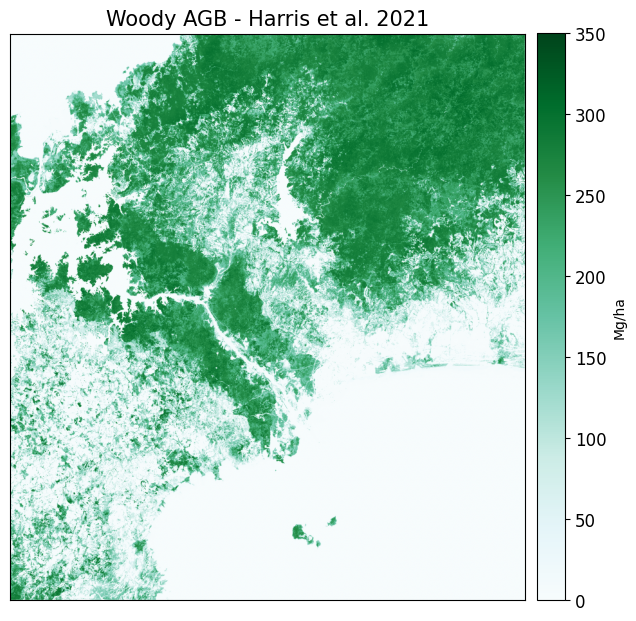

In [8]:
pa_ref_data,_ = dp.get_ref_data(aoi=pa_aoi, file_path='data/Panama/ref_data_abg_woody.tif', 
                                              padding=((0,0), (0,0)), plot=True)

In [9]:
np.max(pa_ref_data)

np.uint16(336)

In [10]:
del pa_s2_data, pa_s1_data, pa_iceye_data, pa_shape_path, pa_s2_rasters, \
    pa_s2_merged_path, pa_s2_path, pa_s1_no_process_path, pa_s1_path, \
    pa_capella_path, pa_iceye_no_process_path, pa_iceye_path, 

#### Formatting for models

In [11]:
pa_n_bands, pa_height, pa_width = pa_combined.shape
n_pixels = pa_height * pa_width

# Reshape to make the bands last
pa_X_2d = np.transpose(pa_combined, (1, 2, 0)).reshape(n_pixels, pa_n_bands)       # (w*h, 14)
pa_y_1d = pa_ref_data.reshape(n_pixels)             # (w*h, )


# For no image processers
# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
pa_X_2d = imputer.fit_transform(pa_X_2d)

# Split into test and train 
pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(
    pa_X_2d, pa_y_1d, test_size=0.3, random_state=42
)

In [12]:
pa_combined = np.nan_to_num(np.expand_dims(np.transpose(pa_combined, (1, 2, 0)),axis=0), nan=0.0, posinf=0.0, neginf=0.0)
pa_ref_data = np.nan_to_num(np.expand_dims(np.transpose(pa_ref_data, (1, 2, 0)),axis=0), nan=0.0, posinf=0.0, neginf=0.0)

In [13]:
del pa_n_bands, n_pixels, pa_y_1d #pa_ref_data, pa_aoi, pa_combined,

# Experiments

### MLR

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self

Training Time: 2.92 seconds
RMSE: 90.73579046817662 Mg/ha
R² Score: 0.3971069532729664


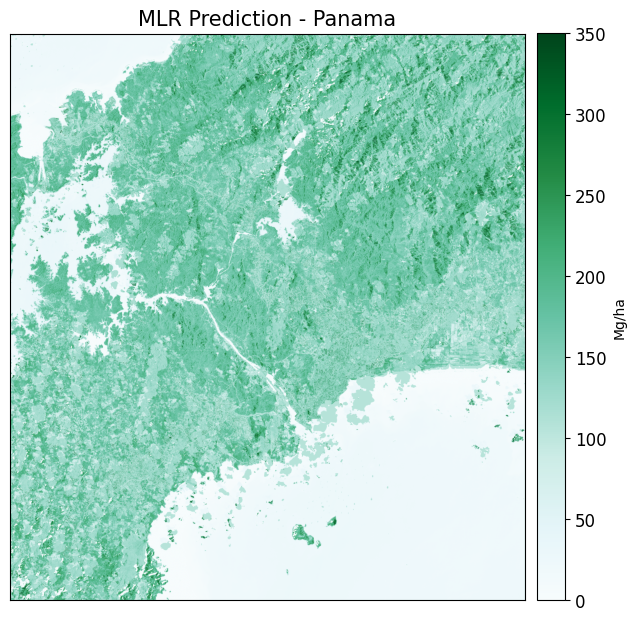

In [13]:
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(pa_X_train, pa_y_train, pa_X_test, pa_y_test, pa_X_2d, pa_height, pa_width, output=True)

if True: # PA_FIRST_LOCATION_RUN
    with open('data/output/pa.txt', 'a') as file:
        file.write('MLR control (%s):\n' % EXPERIMENT_RUN)
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

### RF

##### Parameter experiments

In [14]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all': 
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'rf', pa_X_train, pa_y_train, pa_X_test, 
                                pa_y_test, pa_X_2d, pa_height, pa_width)

    with open('data/output/pa.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


KeyboardInterrupt: 

##### Input data experiments

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   22.4s finished


Training Time: 225.61 seconds
RMSE: 62.743062698349526 Mg/ha
R² Score: 0.7117200424152919


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   35.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   57.1s finished


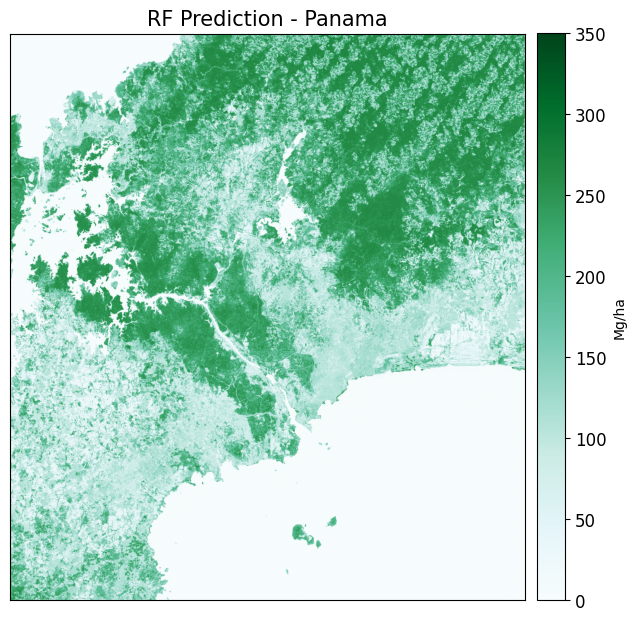

(array([8.41565355e-05, 1.13803156e+02, 1.52527073e+01, ...,
        2.29317573e+02, 9.90921997e+01, 1.61789189e+02]),
 225.61246800422668,
 62.743062698349526,
 0.7117200424152919)

In [14]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [30], NUM_SIMULATIONS, 'rf', pa_X_train, pa_y_train, pa_X_test, 
                                pa_y_test, pa_X_2d, pa_height, pa_width)
    
    with open('data/output/pa.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

m.rf(pa_X_train, pa_y_train, pa_X_test, pa_y_test, pa_X_2d, pa_height, pa_width, output=True, num_trees=50, max_tree_depth=30)

### GBT

##### Parameter experiments

Training Time: 868.95 seconds
RMSE: 64.60269927978516 Mg/ha
R² Score: 0.6943782567977905


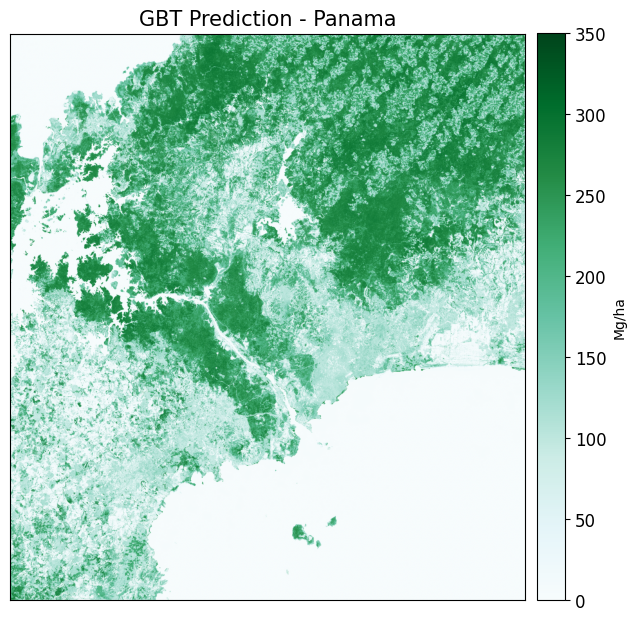

(array([6.9181304e-05, 1.1560636e+02, 2.5252554e+01, ..., 2.2393190e+02,
        1.2061765e+02, 1.6200327e+02], dtype=float32),
 868.9541990756989,
 64.60269927978516,
 0.6943782567977905)

In [15]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

# if EXPERIMENT_RUN == 'all':
#     gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'gbt', pa_X_train, pa_y_train, pa_X_test, 
#                                 pa_y_test, pa_X_2d, pa_height, pa_width)

#     with open('data/output/pa.txt', 'a') as file:
#         file.write('GBT Parameter Experiments Output:\n')
#         file.write(str(gbt_output))
#         file.write('\n\n')
    
#     del gbt_output

m.gbt(pa_X_train, pa_y_train, pa_X_test, pa_y_test, pa_X_2d, pa_height, pa_width, output=True, num_trees=50, max_tree_depth=30)

### CNNs

In [14]:
arch_used = '1simple'
cnn_model, cnn_runtime, cnn_rmse, cnn_r2 = m.cnn(pa_combined, pa_ref_data, output=False, architecture=arch_used)

with open('data/output/pa.txt', 'a') as file:
    file.write('CNN Parameter Experiments Output:\n')
    file.write(str({arch_used: [[cnn_runtime], [cnn_rmse], [cnn_r2]]}))
    file.write('\n\n')

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - cnn_r2_score: 0.1015 - loss: 26223.4844 - root_mean_squared_error: 161.9367
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - cnn_r2_score: 0.0418 - loss: 25003.9863 - root_mean_squared_error: 158.1265
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - cnn_r2_score: 0.0476 - loss: 22672.0742 - root_mean_squared_error: 150.5725
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - cnn_r2_score: 0.0500 - loss: 18780.7520 - root_mean_squared_error: 137.0429
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - cnn_r2_score: 0.0515 - loss: 14524.3389 - root_mean_squared_error: 120.5170
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - cnn_r2_score: 0.0529 - loss: 14513.2539 - root_mean_squared_error: 120.4710
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - cnn_r2_score: 0.0586 - loss: 17079.8027 - root_mean_squared_error: 130.6897
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - cnn_r2_score: 0.0644 - loss: 15003.0127 - root_mean_squared_

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


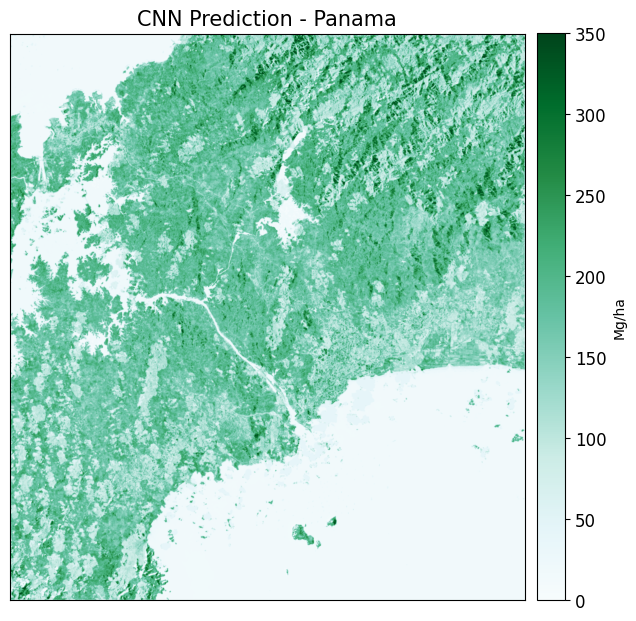

In [15]:
import plotting as p

predicted_output = cnn_model.predict(pa_combined)

p.plot_raster(predicted_output[0], 'CNN Prediction - Panama', 'BuGn', normalized=False, cbar_label='Mg/ha')